# Overview

This is a python script that addresses the following questions:

- What are the most popular departing and destination stations?
- What are the common origination and arrival area clusters (not just based on Zip Code)? 
- Which stations have high operational risks of running out or not supplying enough bikes?

Based on a quick conversation with an actual CitiBike operator who does bike balancing, here are a few operation setup:
- 3 shifts per day (i.e. morning, afternoon, and evening) 
- there are common pattern: tourist destination and commuter centers usually have bike accumulation
- dispatch center will specify an operator how many bike he needs to take and pickup / drop off location
- bikes are re-balanced to nearby stations

# Outputs
- Statistical and Graphical Analysis
- Monte Carlo Simulation for Operational Risk Assessment

# Reference

https://pythonprogramming.net/monte-carlo-simulator-python/

---

## Data Ingestion and Feature Engineering

In [95]:
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import warnings
import matplotlib.style as style
from urllib.request import urlretrieve
import os
from shapely.geometry import Point, LineString
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [96]:
# Download NYC Subway Stations Locations

url = "https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile"

try:
    urlretrieve(url, "subway.zip")
    if os.path.isfile("geo_export_055be448-1761-4ed6-b825-c799a575b2cc.shp"):
        print("Files exist. Pass.")
    else:
        !unzip subway.zip
except:
    pass

subway = gpd.GeoDataFrame.from_file("geo_export_055be448-1761-4ed6-b825-c799a575b2cc.shp")
subway.crs

Files exist. Pass.


{'init': 'epsg:4326'}

In [97]:
subway.head(5)

notes  \
0  4 nights, 6-all times, 6 Express-weekdays AM s...   
1  4 nights, 6-all times, 6 Express-weekdays AM s...   
2                              1-all times, 2-nights   
3           4-nights, 3-all other times, 2-all times   
4                        4-nights, 3-all other times   

                                 url              name  objectid  \
0  http://web.mta.info/nyct/service/          Astor Pl       1.0   
1  http://web.mta.info/nyct/service/          Canal St       2.0   
2  http://web.mta.info/nyct/service/           50th St       3.0   
3  http://web.mta.info/nyct/service/         Bergen St       4.0   
4  http://web.mta.info/nyct/service/  Pennsylvania Ave       5.0   

            line                                      geometry  
0  4-6-6 Express  POINT (-73.99106999861966 40.73005400028978)  
1  4-6-6 Express  POINT (-74.00019299927328 40.71880300107709)  
2            1-2  POINT (-73.98384899986625 40.76172799961419)  
3          2-3-4  POINT (-73.97499915116808 40.68086213682956)  
4            3-4  POINT (-73.89488591154061 40.66471445143568)

In [98]:
# Download NYC Basemap

url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

try:
    urlretrieve(url, "file.zip")
    if os.path.isfile("geo_export_04b91470-87bd-4f6c-bae8-406f62b9cb9a.shp"):
        print("Files exist. Pass.")
    else:
        !unzip file.zip
except:
    pass

nyc_map = gpd.GeoDataFrame.from_file("geo_export_04b91470-87bd-4f6c-bae8-406f62b9cb9a.shp")
nyc_map.crs

Files exist. Pass.


{'init': 'epsg:4326'}

In [99]:
bike = pd.read_csv("https://s3.amazonaws.com/tripdata/201709-citibike-tripdata.csv.zip")
bike.shape

(1878098, 15)

In [100]:
bike.sample(10)

tripduration            starttime             stoptime  \
1004934           244  2017-09-17 16:19:44  2017-09-17 16:23:48   
283970           1757  2017-09-06 19:26:33  2017-09-06 19:55:50   
1786993           459  2017-09-29 12:46:30  2017-09-29 12:54:10   
451393           1337  2017-09-09 13:54:40  2017-09-09 14:16:57   
1064027           374  2017-09-18 16:46:21  2017-09-18 16:52:35   
778948            589  2017-09-14 09:07:19  2017-09-14 09:17:09   
1449152           637  2017-09-24 14:36:12  2017-09-24 14:46:49   
467652           2070  2017-09-09 17:01:11  2017-09-09 17:35:42   
885311           2237  2017-09-15 17:35:47  2017-09-15 18:13:04   
1010487           841  2017-09-17 17:23:25  2017-09-17 17:37:26   

         start station id          start station name  start station latitude  \
1004934               476             E 31 St & 3 Ave               40.743943   
283970                307       Canal St & Rutgers St               40.714275   
1786993               389         Broadway & Berry St               40.710446   
451393                514            12 Ave & W 40 St               40.760875   
1064027               350       Clinton St & Grand St               40.715595   
778948                490             8 Ave & W 33 St               40.751551   
1449152               349     Rivington St & Ridge St               40.718502   
467652               3352  Sigourney St & Columbia St               40.672672   
885311               3096         Union Ave & N 12 St               40.719240   
1010487               312       Allen St & Stanton St               40.722055   

         start station longitude  end station id            end station name  \
1004934               -73.979661             501         FDR Drive & E 35 St   
283970                -73.989900             297             E 15 St & 3 Ave   
1786993               -73.965251            3082         Hope St & Union Ave   
451393                -74.002777             426       West St & Chambers St   
1064027               -73.987030             428              E 3 St & 1 Ave   
778948                -73.993934             468          Broadway & W 56 St   
1449152               -73.983299             326             E 11 St & 1 Ave   
467652                -74.008795            3364          Carroll St & 5 Ave   
885311                -73.952420             293       Lafayette St & E 8 St   
1010487               -73.989111             383  Greenwich Ave & Charles St   

         end station latitude  end station longitude  bikeid    usertype  \
1004934             40.744219             -73.971212   20774  Subscriber   
283970              40.734232             -73.986923   20153  Subscriber   
1786993             40.711674             -73.951413   16671  Subscriber   
451393              40.717548             -74.013221   31100    Customer   
1064027             40.724677             -73.987834   16682  Subscriber   
778948              40.765265             -73.981923   29152  Subscriber   
1449152             40.729538             -73.984267   28651  Subscriber   
467652              40.675162             -73.981483   19655    Customer   
885311              40.730207             -73.991026   27140  Subscriber   
1010487             40.735238             -74.000271   27712    Customer   

         birth year  gender  
1004934      1993.0       1  
283970       1984.0       2  
1786993      1992.0       1  
451393          NaN       0  
1064027      1974.0       2  
778948       1978.0       1  
1449152      1957.0       1  
467652          NaN       0  
885311       1958.0       1  
1010487         NaN       0

In [101]:
bike['starttime'] = pd.to_datetime(bike['starttime'], infer_datetime_format= True)
bike['stoptime'] = pd.to_datetime(bike['stoptime'], infer_datetime_format= True)

In [102]:
print("max time: {} |  min time: {}".format(bike['starttime'].max(), bike['starttime'].min()))

max time: 2017-09-30 23:59:52 |  min time: 2017-09-01 00:00:17


In [103]:
bike['day'] = bike['starttime'].dt.day
bike['start_hour'] = bike['starttime'].dt.hour
bike['end_hour'] = bike['stoptime'].dt.hour
bike['DOW'] = bike['starttime'].dt.dayofweek

In [104]:
bike.sample(10)

tripduration           starttime            stoptime  \
1306194           242 2017-09-22 09:49:30 2017-09-22 09:53:33   
1068786          1182 2017-09-18 17:31:50 2017-09-18 17:51:32   
1368744           701 2017-09-23 10:23:35 2017-09-23 10:35:16   
1740740           613 2017-09-28 18:00:52 2017-09-28 18:11:05   
1355378          1718 2017-09-22 21:30:27 2017-09-22 21:59:05   
701767            253 2017-09-13 08:05:34 2017-09-13 08:09:48   
593184            381 2017-09-11 17:35:23 2017-09-11 17:41:44   
1516279          1717 2017-09-25 16:16:00 2017-09-25 16:44:37   
89622             466 2017-09-02 18:32:00 2017-09-02 18:39:46   
441606           1655 2017-09-09 12:03:00 2017-09-09 12:30:35   

         start station id                start station name  \
1306194               270           Adelphi St & Myrtle Ave   
1068786               526                   E 33 St & 5 Ave   
1368744              3160       Central Park West & W 76 St   
1740740               479                   9 Ave & W 45 St   
1355378               324           DeKalb Ave & Hudson Ave   
701767               3410                 Dean St & Hoyt St   
593184               3134                   3 Ave & E 62 St   
1516279              3350               W 100 St & Broadway   
89622                 476                   E 31 St & 3 Ave   
441606               3349  Grand Army Plaza & Plaza St West   

         start station latitude  start station longitude  end station id  \
1306194               40.693083               -73.971789             324   
1068786               40.747659               -73.984907             473   
1368744               40.778968               -73.973747            3136   
1740740               40.760193               -73.991255             458   
1355378               40.689888               -73.981013            3103   
701767                40.686444               -73.987591             467   
593184                40.763126               -73.965269            3140   
1516279               40.797372               -73.970412             529   
89622                 40.743943               -73.979661            2003   
441606                40.672968               -73.970880             443   

                   end station name  end station latitude  \
1306194     DeKalb Ave & Hudson Ave             40.689888   
1068786  Rivington St & Chrystie St             40.721101   
1368744             5 Ave & E 63 St             40.766368   
1740740            11 Ave & W 27 St             40.751396   
1355378         N 11 St & Wythe Ave             40.721533   
701767              Dean St & 4 Ave             40.683125   
593184              1 Ave & E 78 St             40.771404   
1516279             W 42 St & 8 Ave             40.757570   
89622               1 Ave & E 18 St             40.733812   
441606         Bedford Ave & S 9 St             40.708531   

         end station longitude  bikeid    usertype  birth year  gender  day  \
1306194             -73.981013   21205  Subscriber      1991.0       1   22   
1068786             -73.991925   27687  Subscriber      1972.0       1   18   
1368744             -73.971518   17401    Customer         NaN       0   23   
1740740             -74.005226   15402  Subscriber      1969.0       2   28   
1355378             -73.957824   25033  Subscriber      1993.0       1   22   
701767              -73.978951   25265  Subscriber      1991.0       2   13   
593184              -73.953517   17683  Subscriber      1978.0       1   11   
1516279             -73.990985   15135  Subscriber      1975.0       1   25   
89622               -73.980544   20845  Subscriber      1985.0       2    2   
441606              -73.964090   29942    Customer         NaN       0    9   

         start_hour  end_hour  DOW  
1306194           9         9    4  
1068786          17        17    0  
1368744          10        10    5  
1740740          18        18    3  
1355378          21        21    4 

---

## Quantitative Analysis
- Find all unique station and its location details
- Count the number of trips and group by starting and ending station accordingly
- Create a table of bike station, hour, total # of departure, total # of arrival, # of bikes at the dock, and lat/long; assuming there are 20 bikes at the beginning of the day at 12 a.m.

In [105]:
uni_dep_stations = bike[['start station id', 'start station name', 
                         'start station latitude', 'start station longitude']].drop_duplicates()

uni_arv_stations = bike[['end station id', 'end station name', 
                         'end station latitude', 'end station longitude']].drop_duplicates()

In [106]:
print ("number of unique departure stations: {}".format(uni_dep_stations.shape[0]))

number of unique departure stations: 680


In [107]:
print ("number of unique arrival stations: {}".format(uni_arv_stations.shape[0]))

number of unique arrival stations: 696


In [108]:
# Create a dataset with all unique station id, name, and lat/lon
uni_dep_stations.columns = ["id", "name", "lat", "lon"]
uni_arv_stations.columns = ["id", "name", "lat", "lon"]
uni_station = pd.concat([uni_dep_stations, uni_arv_stations], axis = 0).drop_duplicates()
uni_station.head()

# Convert to Geo DataFrame
uni_station['geometry'] =  uni_station.apply(lambda x: Point((float(x.lon)), (float(x.lat))), axis = 1)
uni_station = gpd.GeoDataFrame(uni_station, geometry = 'geometry').drop(uni_station[uni_station.lon ==0].index)
uni_station.head()

id                      name        lat        lon  \
0  3331   Riverside Dr & W 104 St  40.801343 -73.971146   
1  3101     N 12 St & Bedford Ave  40.720798 -73.954847   
2  3140           1 Ave & E 78 St  40.771404 -73.953517   
3   236       St Marks Pl & 2 Ave  40.728419 -73.987140   
4  3427  Lafayette St & Jersey St  40.724305 -73.996010   

                                       geometry  
0         POINT (-73.97114574390001 40.8013434)  
1              POINT (-73.95484712 40.72079821)  
2               POINT (-73.9535166 40.77140426)  
3               POINT (-73.98713956 40.7284186)  
4  POINT (-73.99600982666016 40.72430527250332)

In [109]:
print ("number of unique stations: {}".format(uni_station.shape[0]))

number of unique stations: 694


### Top 5 Stations with The Most Departure Trips in Sept. 2017

In [110]:
start_count = bike.groupby("start station id").size().reset_index(name = "departure_cnt").\
                sort_values(by = "departure_cnt", ascending = False)
start_count = start_count.merge(uni_dep_stations, how = "left", left_on = "start station id", right_on = "id")
start_count.head(5)

start station id  departure_cnt   id                   name        lat  \
0               519          17359  519  Pershing Square North  40.751873   
1               426          13132  426  West St & Chambers St  40.717548   
2               497          12391  497     E 17 St & Broadway  40.737050   
3               435          11517  435        W 21 St & 6 Ave  40.741740   
4               402          11483  402     Broadway & E 22 St  40.740343   

         lon  
0 -73.977706  
1 -74.013221  
2 -73.990093  
3 -73.994156  
4 -73.989551

### Top 5 Stations with The Most Arrival Trip in Sept. 2017

In [111]:
end_count = bike.groupby("end station id").size().reset_index(name = "arrival_cnt").\
                sort_values(by = "arrival_cnt", ascending = False)
end_count = end_count.merge(uni_arv_stations, how = "left", left_on = "end station id", right_on = "id")
end_count.head(5)

end station id  arrival_cnt   id                   name        lat  \
0             519        17056  519  Pershing Square North  40.751873   
1             426        14917  426  West St & Chambers St  40.717548   
2             497        12704  497     E 17 St & Broadway  40.737050   
3             402        11830  402     Broadway & E 22 St  40.740343   
4             435        11668  435        W 21 St & 6 Ave  40.741740   

         lon  
0 -73.977706  
1 -74.013221  
2 -73.990093  
3 -73.989551  
4 -73.994156

### The Stations with the Most and Least Bike Balance on Sept 1, 2017

- create dataset of # of arrival by hour
- create dataset of # of departure by hour
- create dataset with net flow by hour
- create dataset with end-of-hour bike balances; assume 20 bikes at 12am

Technique
- long-to-wide table transpose - https://pandas.pydata.org/pandas-docs/stable/reshaping.html

In [112]:
bike.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
day                                 int64
start_hour                          int64
end_hour                            int64
DOW                                 int64
dtype: object

In [113]:
# Create hourly departure count by day across the month

monthDep = pd.pivot_table(bike[['start station id', 'day','start_hour']],
                             index = "start station id", columns = ['day', "start_hour"], 
                             aggfunc = np.size, fill_value= 0).reset_index()

monthDep.columns = ["dep_" + str(day) + "_" + str(hour) for day, hour in monthDep.columns]

In [114]:
# Create hourly arrival count by day across the month

monthArv = pd.pivot_table(bike[['end station id', 'day','end_hour']],
                             index = "end station id", columns = ['day', "end_hour"], 
                             aggfunc = np.size, fill_value= 0).reset_index()

monthArv.columns = ["arv_" + str(day) + "_" + str(hour) for day, hour in monthArv.columns]

In [115]:
# Create a hourly net flow count by day across the month 

monthNet = uni_station.merge(monthDep, how = "left", left_on = "id", right_on = "dep_start station id_").\
                      merge(monthArv, how = "left", left_on = "id", right_on = "arv_end station id_").fillna(0)

for day in range(1, 31):
        
    for hour in range(0, 24):
        
        try:
            net_col = "net_" + str(day) + "_" + str(hour)
            dep_col = "dep_" + str(day) + "_" + str(hour)
            arv_col = "arv_" + str(day) + "_" + str(hour)
            monthNet[net_col] = monthNet[arv_col] - monthNet[dep_col]
        except (KeyError):
            print("Missing day: {} | Missing hour: {}".format(day, hour))
            pass

monthNet.sample(10)

id                        name        lat        lon  \
20    346         Bank St & Hudson St  40.736529 -74.006180   
214  3118  McGuinness Blvd & Eagle St  40.735550 -73.952840   
378   253             W 13 St & 5 Ave  40.735439 -73.994539   
469  3169      Riverside Dr & W 82 St  40.787209 -73.981281   
356   419      Carlton Ave & Park Ave  40.695807 -73.973556   
658  3568              34 St & 35 Ave  40.756933 -73.926223   
163  3298        Warren St & Court St  40.686371 -73.993833   
24     72            W 52 St & 11 Ave  40.767272 -73.993929   
649  3538    W 110 St & Amsterdam Ave  40.802692 -73.962950   
146   383  Greenwich Ave & Charles St  40.735238 -74.000271   

                                         geometry  dep_start station id_  \
20         POINT (-74.00618025999999 40.73652889)                  346.0   
214           POINT (-73.95284000000001 40.73555)                 3118.0   
378              POINT (-73.99453948 40.73543934)                  253.0   
469              POINT (-73.98128127 40.78720869)                 3169.0   
356              POINT (-73.97355569 40.69580705)                  419.0   
658  POINT (-73.92622309999999 40.75693320000001)                 3568.0   
163                POINT (-73.99383324 40.686371)                 3298.0   
24               POINT (-73.99392888 40.76727216)                   72.0   
649          POINT (-73.96295000000001 40.802692)                 3538.0   
146                  POINT (-74.000271 40.735238)                  383.0   

     dep_1_0  dep_1_1  dep_1_2  dep_1_3  dep_1_4  dep_1_5  dep_1_6  dep_1_7  \
20       6.0     12.0      6.0      0.0      3.0      0.0      9.0     21.0   
214      3.0      0.0      0.0      0.0      0.0      0.0      6.0     12.0   
378      0.0      0.0      0.0      0.0      0.0      3.0      0.0      6.0   
469      0.0      0.0      0.0      0.0      0.0      0.0     12.0     15.0   
356      0.0      0.0      0.0      0.0      3.0      0.0      9.0      0.0   
658      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
163      3.0      0.0      0.0      0.0      0.0      0.0      6.0      6.0   
24       3.0      3.0      0.0      3.0      0.0      0.0      3.0      9.0   
649      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
146      6.0      9.0      6.0      0.0      0.0      9.0      9.0     21.0   

     dep_1_8  dep_1_9  dep_1_10  dep_1_11  dep_1_12  dep_1_13  dep_1_14  \
20      36.0     15.0      21.0      15.0      12.0      18.0       9.0   
214     27.0     30.0       9.0       3.0       3.0       9.0       3.0   
378     24.0     33.0      27.0      42.0      39.0      45.0      36.0   
469     45.0     18.0      12.0      15.0       6.0       9.0       9.0   
356     15.0     21.0       6.0       0.0       3.0       3.0       0.0   
658      0.0      0.0       0.0       0.0       0.0       0.0       0.0   
163      9.0      9.0       3.0       9.0       0.0       9.0       9.0   
24      39.0     27.0      15.0      21.0      12.0      24.0      12.0   
649      0.0      0.0       0.0       0.0       0.0       0.0       0.0   
146     36.0     24.0      36.0      24.0      36.0      21.0      21.0   

     dep_1_15  dep_1_16  dep_1_17  dep_1_18  dep_1_19  dep_1_20  dep_1_21  \
20       12.0      24.0      24.0      30.0      18.0       9.0      15.0   
214       9.0      12.0       6.0       9.0      15.0       6.0      12.0   
378      42.0      24.0      48.0      30.0      24.0       6.0      18.0   
469       3.0      18.0      12.0       9.0       9.0       6.0       0.0   
356      15.0       3.0       3.0       3.0       3.0       0.0       6.0   
658       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
163       9.0       6.0      12.0      12.0       9.0       3.0       9.0   
24       39.0      12.0      33.0      33.0      18.0       3.0       3.0   
649       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
146      3

In [116]:
# Calculate end-of-hour bike balance and percentage change 

def calHourlyBal(df, starting_bal):
    
    hourBal = df
    
    # Calculate hourly bike balance based on starting stock
    for day in range(1, 31):
        for hour in range(0, 24):
            try:
                
                if day == 1 and hour == 0:
                    bal_col = "bal_1_0"
                    hourBal["bal_1_0"] = starting_bal
                    
                elif day > 1 and hour == 0:
                    
                    bal_col = "bal_" + str(day) + "_" + str(hour)
                    last_bal_col = "bal_" + str(day-1) + "_23"
                    net_col = "net_" + str(day) + "_0"
                    
                    hourBal[bal_col] = hourBal[last_bal_col] + hourBal[net_col]
                
                else:
                    
                    bal_col = "bal_" + str(day) + "_" + str(hour)
                    last_bal_col = "bal_" + str(day) + "_" + str(hour-1)
                    net_col = "net_" + str(day) + "_" + str(hour)
                                        
                    hourBal[bal_col] = hourBal[last_bal_col] + hourBal[net_col]
            
            except (KeyError) as ex:
                # use previous balance for missing time slot
                print("Missing net flow at day {} hour {}".format(day, hour))
                
                #hourBal[bal_col] = hourBal[last_bal_col]
                pass

    # Calculate % change relative to starting stock
    for day in range(1, 31):
        for hour in range(0, 24):
            try:

                if day == 1 and hour == 0:
                    hourBal["chg_1_0"] = 1

                else:
                    chg_col = "chg_"+str(day)+ "_" + str(hour)
                    bal_col = "bal_"+str(day)+ "_" + str(hour)
                    hourBal[chg_col] = hourBal[bal_col] / hourBal["bal_1_0"]
            
            except (KeyError) as ex:
                # use previous balance for missing time slot
                print("Missing: {} col".format(ex))
                last_chg_col = "chg_" + str(i-1)
                hourBal[chg_col] = hourBal[last_chg_col]
                pass
    
    # Only keep balance and change columns
    bal_col = hourBal.columns[hourBal.columns.str.contains("bal_")]
    chg_col = hourBal.columns[hourBal.columns.str.contains("chg_")]

    final_bal = pd.concat([hourBal[["id", "name", "lat", "lon"]], hourBal[bal_col]], axis = 1) 
    final_chg = pd.concat([hourBal[["id", "name", "lat", "lon"]], hourBal[chg_col]], axis = 1)
    
    return final_bal, final_chg

In [117]:
# Calculate hourly bike balance and relative change based on a starting amount

final_bal, final_chg = calHourlyBal(monthNet, 50)

---

## Visual Analysis

In [118]:
# Plot Time Series of net flow by station and hour

def plot_change(df, first_hour, last_hour):
    
    '''
    This function plots the % change of bike stock based on selected hour range
    '''
    listStation = []
    # convert to list
    
    for i in range(0, df.shape[0]):
        listStation.append(df.iloc[i, first_hour + 4: last_hour + 4].values.tolist())
    
    
    # Visualize
    fig = plt.figure(figsize = (13, 15));
    ax = fig.add_subplot(111);
    x_tick = range(first_hour, last_hour)
    for station in range(0, len(listStation)):
        
        plt.plot(x_tick, listStation[station], linewidth = 1)
    
    
    plt.xticks(np.arange(min(x_tick), max(x_tick)+1, int((min(x_tick)+max(x_tick)+1)/10)));
    plt.xlabel("Hours Window of Analysis", size = 12);
    plt.ylabel("Multiple of Bike Inventory compared to Initial Amount", size = 12);
    plt.title("Relative Bike Stock in Sept, 2017 from {} to {} hours".format(first_hour, last_hour), size = 18);
    

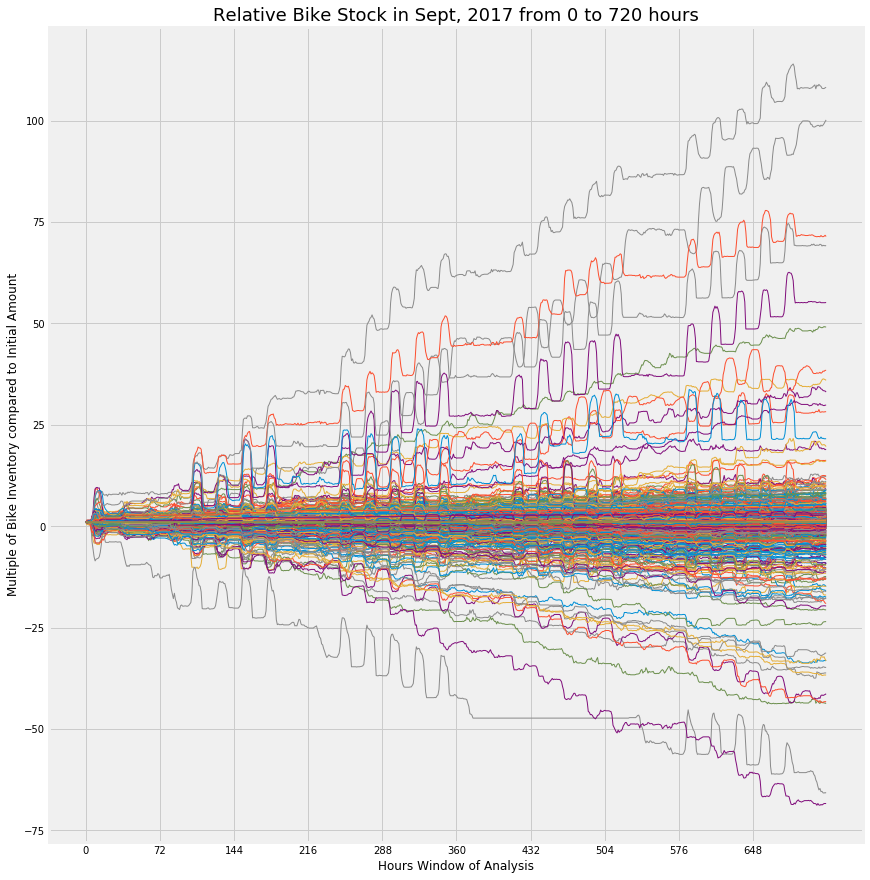

In [119]:
# Plot based on hour range
plot_change(final_chg, 0, 720)

### Figure 1

This is a time series chart of the multiple of bike inventory by hours from Sept 1 to 30, 2017 of all 696 stations. The visualization shows clear commutor pattern at certain stations. The ones with chainsaw patterns suggests morning and evening rush hour spikes follow by steady usage over the weekend. 

In addition, some stations accumulate bike much faster than others over a period of a month. This is a not true representation because assumptions regarding initial bike inventory at each stations were set to 50, it is used to calculate inventory for all subsequent hourly bike inventory based on departure and arrival trips. In reality, different stations have different avereage bike inventory depending on the locaiton. The current re-balancing is not taken into account because such information is not available. With re-balancing, the bike inventory will be re-set to a certain level about 3 times a day. This will drastically reduce the accumulation effect. 

This can be considered as **a baseline scenario without re-balancing**.

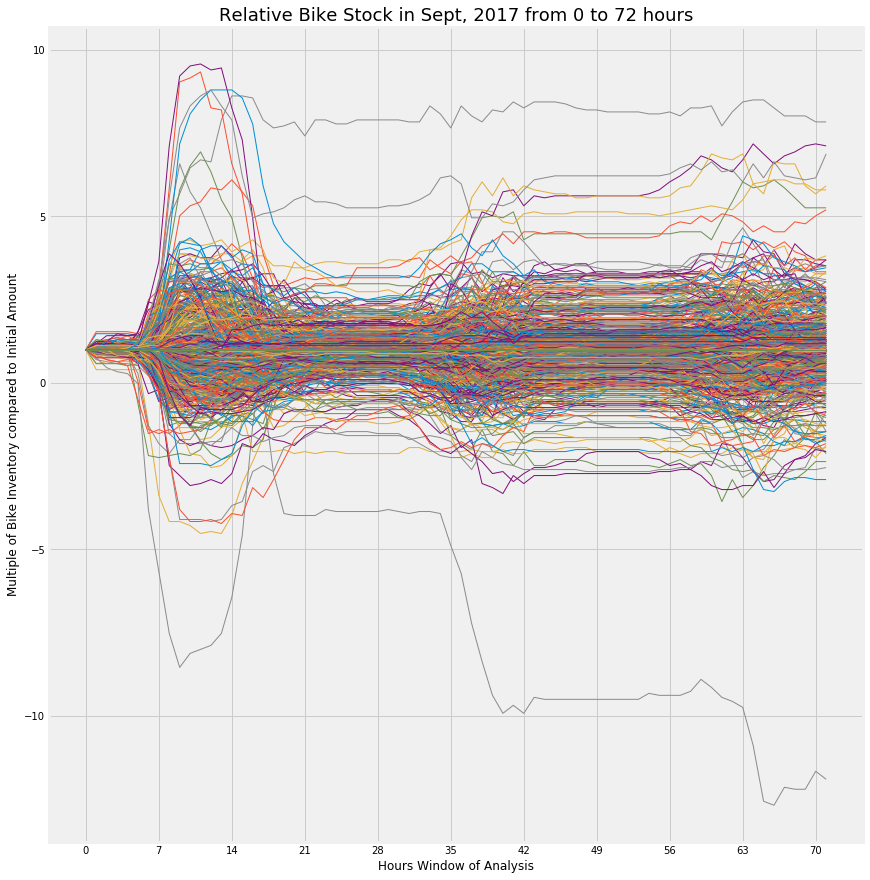

In [120]:
plot_change(final_chg, 0, 72)

### Figure 2

This is a time series plot of bike balance at end of each hour assuming there are **50 bikes** at 12am on Sep 1, 2017. This graph include 696 stations that have any activities on Sept 1, 2017. Due to the space limit, the list of stations with the most and least bike balance at 23pm is shown below.

This visual analysis shows general departure and arrival traffic during rush hours from around 7-11am and 5-7pm. The bike balance at certain hours suggest that some stations are the popular destinations (e.g. grey line) and others are oringiation stations (e.g. green line). 

In [121]:
# Top 5 stations with the most bike at 11pm, Sept 30, 2017
final_bal.sort_values(by = "bal_30_23", ascending= False).head(5)[["id", "name", "bal_30_23"]]

id                   name  bal_30_23
106   426  West St & Chambers St     5411.0
136   432      E 7 St & Avenue A     5009.0
253   304  Broadway & Battery Pl     3572.0
334   520        W 52 St & 5 Ave     3455.0
263  3443        W 52 St & 6 Ave     2759.0

In [122]:
# Top 5 stations with the least bike at 11pm, Sept 30, 2017
final_bal.sort_values(by = "bal_30_23", ascending= True).head(5)[["id", "name", "bal_30_23"]]

id                               name  bal_30_23
197  3164             Columbus Ave & W 72 St    -3418.0
76    281  Grand Army Plaza & Central Park S    -3289.0
45    499                 Broadway & W 60 St    -2185.0
295  3161             W 76 St & Columbus Ave    -2164.0
239   487                E 20 St & FDR Drive    -2065.0

# Insights & Discussion
Some stations experience over-stock while some sees under-supply of bikes throughout the day. Assuming 20 initial bikes at 12am, some stations accumulates about **5-10 times** of the original bike stock throughout the day in the first 72 hours. In this case, riders may not be able to find a dock to park the bike unless they travel to a nearby station. This suggests the planning of # of free bike rack is important to avoid overflowing of bike. 

In contrast, some stations experience high demands of bikes for departure trips, **~5-8 times** the original bike stock. Having enough bikes at these high demand stations is critical to service delivery. This insight is reflective of actual situations. According to CitiBike website, they offer valet stations at peak hours to offer more bikes and docks to alleviate the gap of the supply-demand of bike and docking stations. These valet stations are near Penn Station, Port Authority, lower Manhattan.

The relative change in bike stock obviosly will change depanding on the initial assumption of bike stock. This visual analysis provides a directional sense of the dynamics of how bike stocks accumulate or deplete during the day. With this mechanism, one can develop a station-specific optimiazation model to determine the optimal amount of initial bike stock, which informs the amount of rebalancing, to minimize the "bike inventory" stress.

---

## Clustering Analysis

- Create clustering features
- Perform K-Means Clustering
- Visualize on a Geo Spatial Map

In [123]:
# Convert data frame to Geo Pandas
from shapely.geometry import Point
#final_bal = final_bal.sort_values("bal_30_23")
final_chg["geometry"] = final_chg.apply(lambda x: Point((float(x.lon)), (float(x.lat))), 
                                        axis = 1)
geo_final_chg = gpd.GeoDataFrame(final_chg, geometry = "geometry", crs = nyc_map.crs)
geo_final_chg.drop(geo_final_chg[geo_final_chg.lon ==0].index, inplace = True)
del final_chg, final_bal

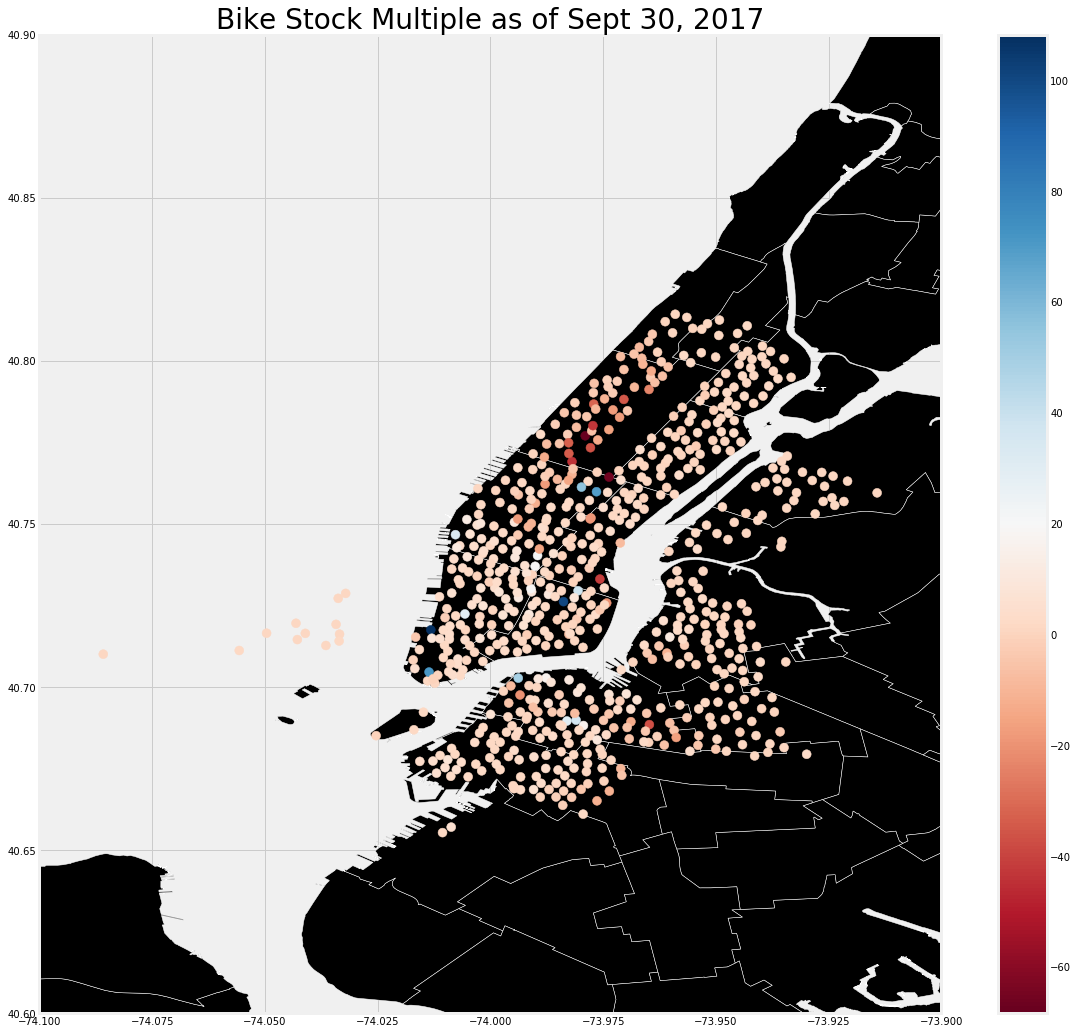

In [124]:
f, ax = plt.subplots(figsize = (18, 18));
nyc_map.plot(ax = ax, color = "black", edgecolor = 'w');
geo_final_chg.plot(ax = ax, column = "chg_30_23", cmap = "RdBu", 
                   markersize = 80, legend = True);
plt.xlim((-74.1, -73.9));
plt.ylim((40.6, 40.9));
plt.title("Bike Stock Multiple as of Sept 30, 2017", size = 28);

### Figure 3:

This is a geospatial map of bike stock by Sept 30, 2017 of each CitiBike Station. The stock was calculated based on actual net flow (departure - arrival) of each hour of each day with an assumption of starting stock of 20 at 12am, Sept 1, 2017.

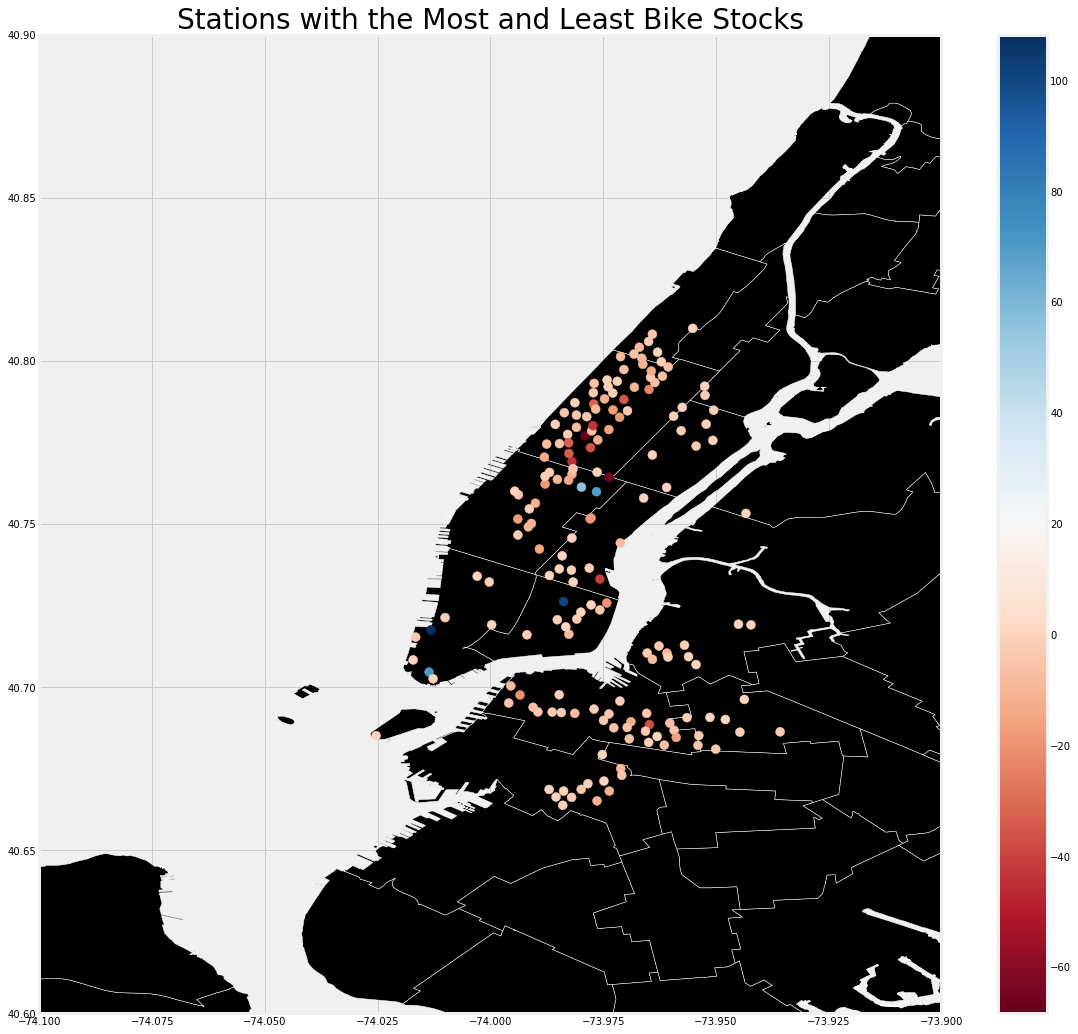

In [125]:
f, ax = plt.subplots(figsize = (18, 18));
nyc_map.plot(ax = ax, color = "black", edgecolor = 'w');
geo_final_chg[(geo_final_chg.chg_30_23 > 50) | (geo_final_chg.chg_30_23 < 0)]\
            .plot(ax = ax, column = "chg_30_23", 
                  cmap = "RdBu", markersize = 80, legend = True);
plt.xlim((-74.1, -73.9));
plt.ylim((40.6, 40.9));
plt.title("Stations with the Most and Least Bike Stocks", size = 28);

### Figure 4:

This is a geo-spatial map of the stations with the most and least amount of bikes, which is measured by multiple of original stock on Sept 1, 2017). The blues are the most popular destinations and the reds are the most common departure locations.

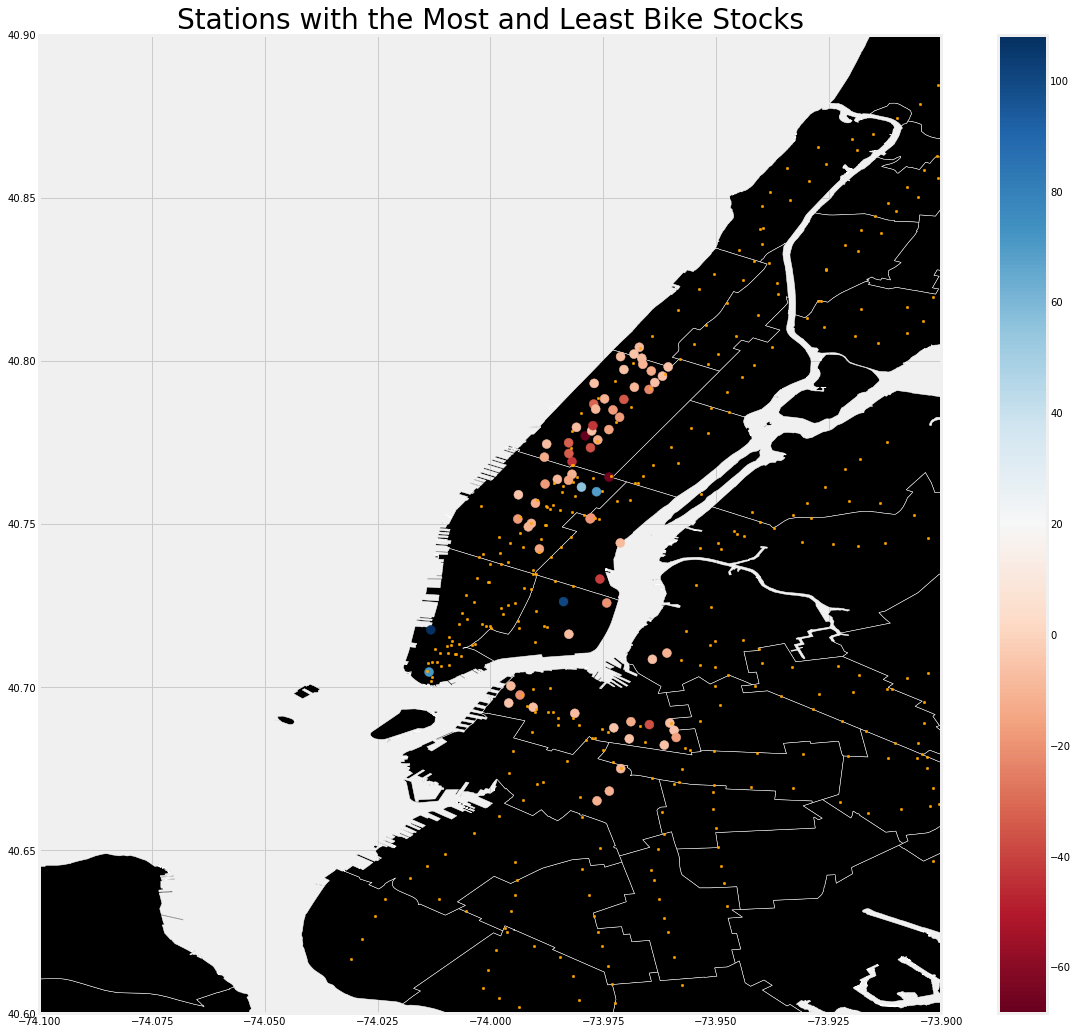

In [126]:
f, ax = plt.subplots(figsize = (18, 18));
nyc_map.plot(ax = ax, color = "black", edgecolor = 'w');
geo_final_chg[(geo_final_chg.chg_30_23 > 50) | (geo_final_chg.chg_30_23 < -5)]\
            .plot(ax = ax, column = "chg_30_23", 
                  cmap = "RdBu", markersize = 80, legend = True);

subway.plot(ax = ax, color = "orange", markersize = 6);

plt.xlim([-74.1, -73.9]);
plt.ylim([40.6, 40.9]);
plt.title("Stations with the Most and Least Bike Stocks", size = 28);

### Figure 5

This is a geo-spatial map that overlays the most popular destinations (blue) and origins (red) with NYC Subway entrances (small organe dots). It seems some popular citibike destinations and origins are more remote from the subway entrances, such as the ones on lower west Manhattan.

## The Most Common Routes


In [127]:
bike[(bike["start station id"] == bike["end station id"])].head()

tripduration           starttime            stoptime  start station id  \
39           7728 2017-09-01 00:04:08 2017-09-01 02:12:56               376   
78           2951 2017-09-01 00:07:36 2017-09-01 00:56:47               478   
80           7537 2017-09-01 00:07:49 2017-09-01 02:13:26               376   
120          5538 2017-09-01 00:12:04 2017-09-01 01:44:23               462   
142           462 2017-09-01 00:13:58 2017-09-01 00:21:41              3244   

         start station name  start station latitude  start station longitude  \
39     John St & William St               40.708621               -74.007222   
78         11 Ave & W 41 St               40.760301               -73.998842   
80     John St & William St               40.708621               -74.007222   
120        W 22 St & 10 Ave               40.746920               -74.004519   
142  University Pl & E 8 St               40.731437               -73.994903   

     end station id        end station name  end station latitude  \
39              376    John St & William St             40.708621   
78              478        11 Ave & W 41 St             40.760301   
80              376    John St & William St             40.708621   
120             462        W 22 St & 10 Ave             40.746920   
142            3244  University Pl & E 8 St             40.731437   

     end station longitude  bikeid    usertype  birth year  gender  day  \
39              -74.007222   17371    Customer         NaN       0    1   
78              -73.998842   16186    Customer         NaN       0    1   
80              -74.007222   18893    Customer         NaN       0    1   
120             -74.004519   16564  Subscriber      1979.0       1    1   
142             -73.994903   28396  Subscriber      1965.0       1    1   

     start_hour  end_hour  DOW  
39            0         2    4  
78            0         0    4  
80            0         2    4  
120           0         1    4  
142           0         0    4

In [173]:
# Create Pairwise Station Route and Count

commonRoute = bike.groupby(["start station id", "end station id"]).size().reset_index(name="cnt")
commonRoute.sort_values("cnt", ascending= False).head()

start station id  end station id  cnt
91407              2006            2006  856
80977               514             426  781
56852               432            3263  770
91484              2006            3282  701
19228               281             281  578

In [174]:
# Bring Back the lat / long information

commonRoute = commonRoute.merge(uni_dep_stations, how = "left", 
                                left_on = "start station id", right_on = "id").drop("id", axis = 1)

commonRoute.columns.values[-3:] = ['name_dep','lat_dep', 'lon_dep']

commonRoute = commonRoute.merge(uni_arv_stations, how = "left", 
                                left_on = "end station id", right_on = "id").drop("id", axis = 1)

commonRoute.columns.values[-3:] = ['name_arv','lat_arv', 'lon_arv']

In [175]:
commonRoute.shape

(164733, 9)

In [176]:
commonRoute["geometry_dep"] = commonRoute.apply(lambda x: Point((float(x.lon_dep)), (float(x.lat_dep))), axis = 1)

commonRoute["geometry_arv"] = commonRoute.apply(lambda x: Point((float(x.lon_arv)), (float(x.lat_arv))), axis = 1)


In [177]:
commonRoute = gpd.GeoDataFrame(commonRoute, geometry= "geometry_arv")
commonRoute.head()

start station id  end station id  cnt          name_dep    lat_dep  \
0                72              72   79  W 52 St & 11 Ave  40.767272   
1                72              79    4  W 52 St & 11 Ave  40.767272   
2                72             116    9  W 52 St & 11 Ave  40.767272   
3                72             127   15  W 52 St & 11 Ave  40.767272   
4                72             128    5  W 52 St & 11 Ave  40.767272   

     lon_dep                  name_arv    lat_arv    lon_arv  \
0 -73.993929          W 52 St & 11 Ave  40.767272 -73.993929   
1 -73.993929  Franklin St & W Broadway  40.719116 -74.006667   
2 -73.993929           W 17 St & 8 Ave  40.741776 -74.001497   
3 -73.993929     Barrow St & Hudson St  40.731724 -74.006744   
4 -73.993929  MacDougal St & Prince St  40.727103 -74.002971   

                       geometry_dep                            geometry_arv  
0  POINT (-73.99392888 40.76727216)        POINT (-73.99392888 40.76727216)  
1  POINT (-73.99392888 40.76727216)        POINT (-74.00666661 40.71911552)  
2  POINT (-73.99392888 40.76727216)        POINT (-74.00149746 40.74177603)  
3  POINT (-73.99392888 40.76727216)        POINT (-74.00674436 40.73172428)  
4  POINT (-73.99392888 40.76727216)  POINT (-74.00297088000001 40.72710258)

In [196]:
commonRoute.sort_values("cnt", ascending = False)['start station id'].drop_duplicates().iloc[0:10].values

array([2006,  514,  432,  281,  426, 3254, 3479, 3256,  387, 3182])

In [197]:
def plotTopRoute(commonRoute, top_routes, top_destination):
    
    '''
    This function plots the orgination and top X destinations of the top Y common routes. 
    Input: 
        commonRoute = data frame of routes with starting and end staions, counts, and lat/lon
        top_routes = number of top routes; 
        top_destination = number of top destination of each origin
    Return: None; It outputs graphs.
    '''
    # Get the Top Routes and the Starting Location
    unique_top_origin = commonRoute.sort_values("cnt", ascending = False)['start station id']\
                                   .drop_duplicates().iloc[0:int(top_routes)].values
    
    # Plot the Origination Station (Star) and its corresponding Top Destinations (Dots)
    for station in unique_top_origin:

        f, ax = plt.subplots(figsize = (10,10));
        nyc_map.plot(ax = ax, color = "black", edgecolor = 'w');

        commonRoute[(commonRoute["start station id"] == station)]\
                    [["end station id", "cnt", "geometry_arv"]].sort_values("cnt", ascending = False)\
                    .iloc[0:int(top_destination), :]\
                    .plot(ax = ax, column = "cnt", cmap = "Oranges", markersize = 80, legend = True);

        uni_station[(uni_station.id == station)].plot(ax = ax, color = "blue", marker = "*", markersize = 200);
        station_name = uni_station[(uni_station.id == station)]["name"].values

        plt.xlim([-74.1, -73.9]);
        plt.ylim([40.6, 40.9]);
        plt.title("Top {} Destination and Trips Counts of: {}"\
                  .format(top_destination, station_name[0]), size = 12);

[2006  514  432  281  426 3254 3479 3256  387 3182  519  435  460 3263 3118]


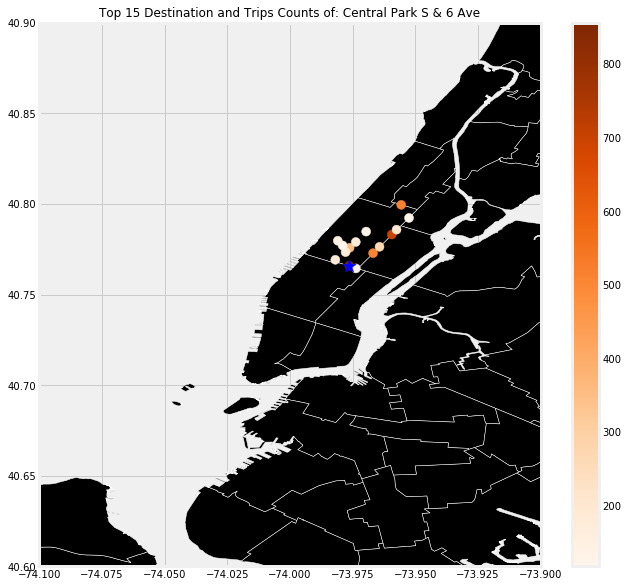

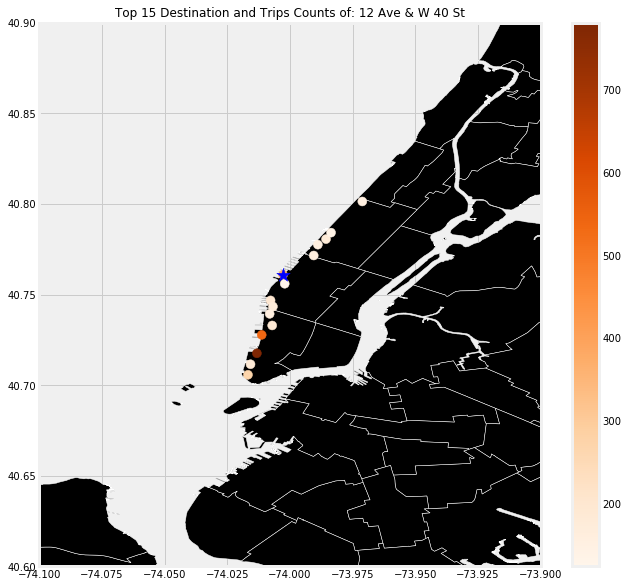

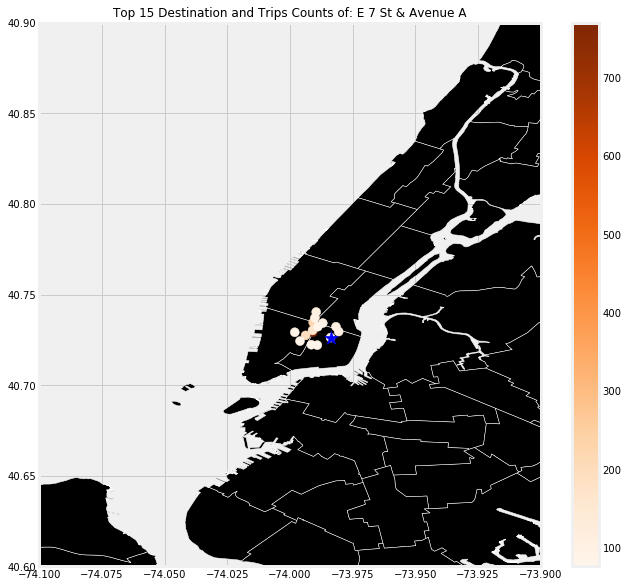

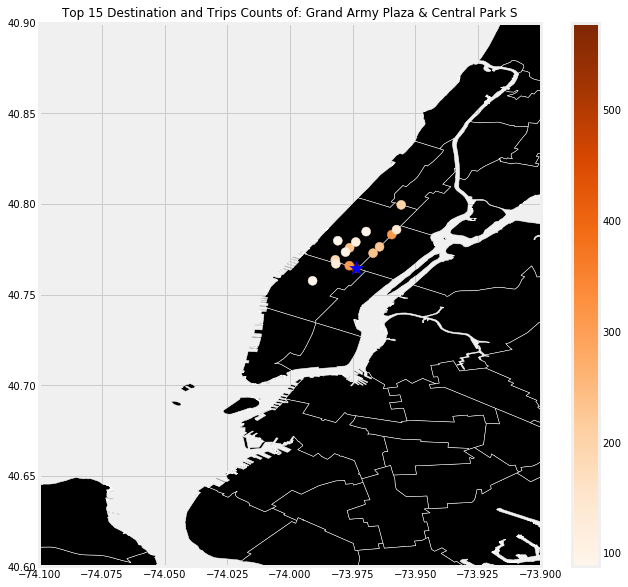

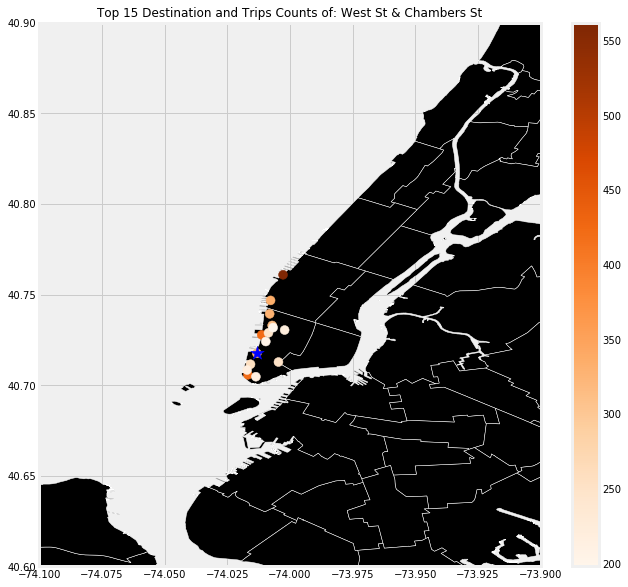

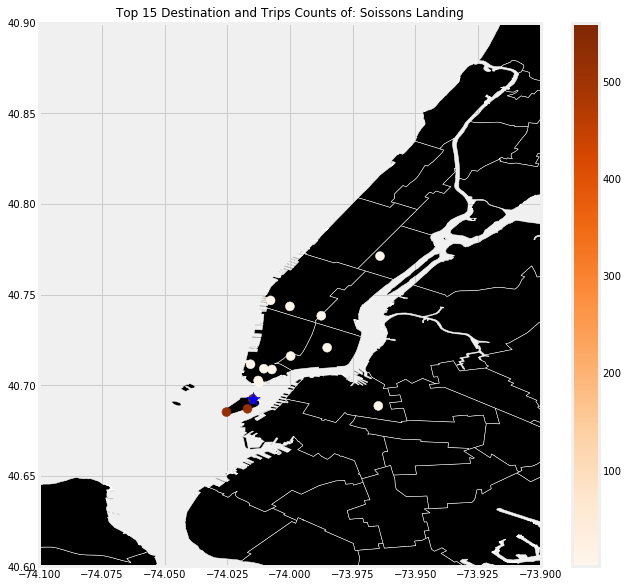

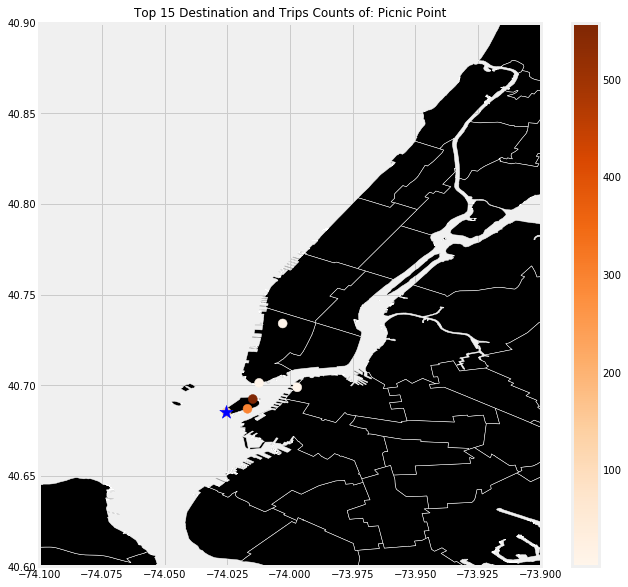

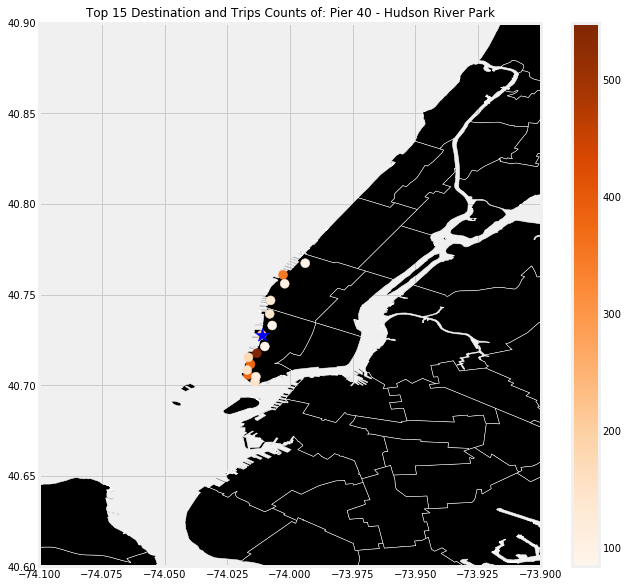

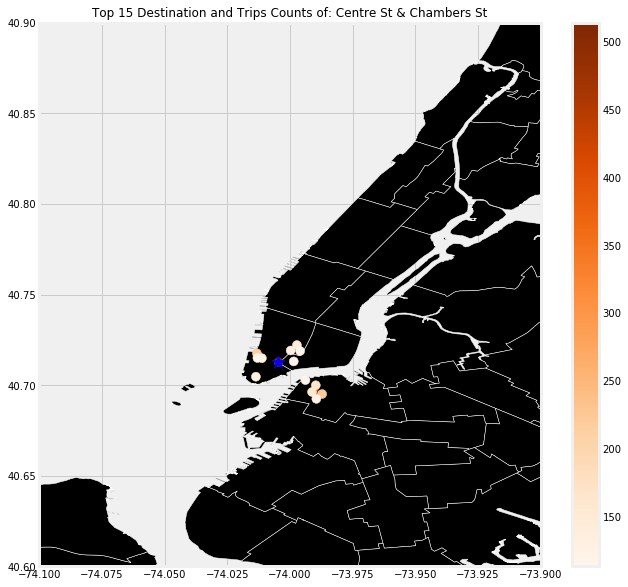

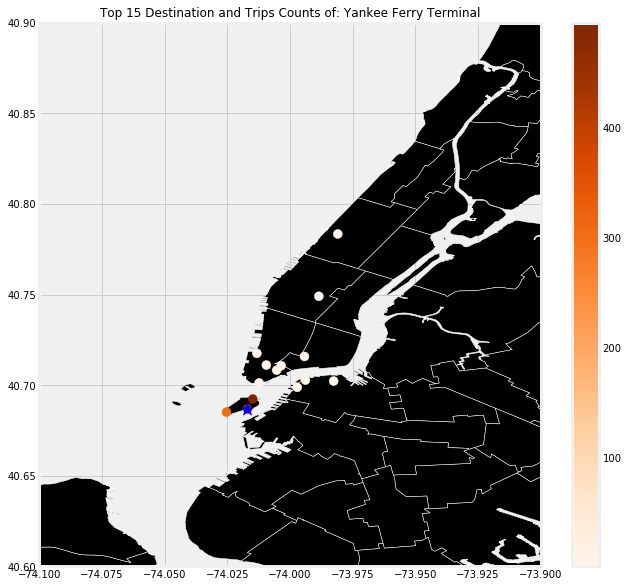

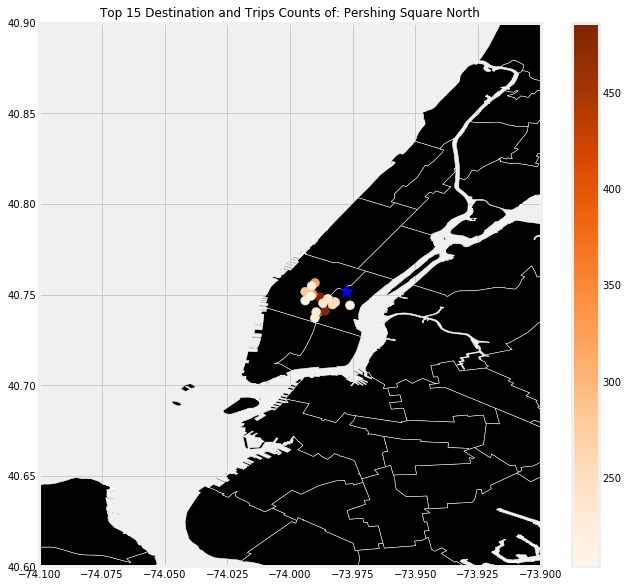

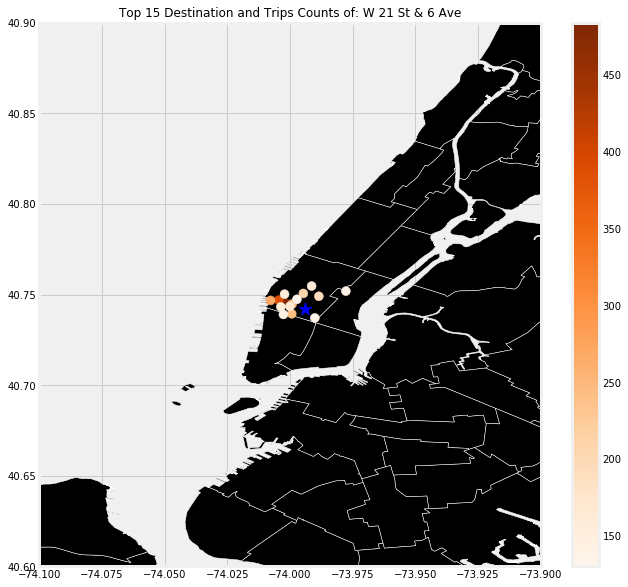

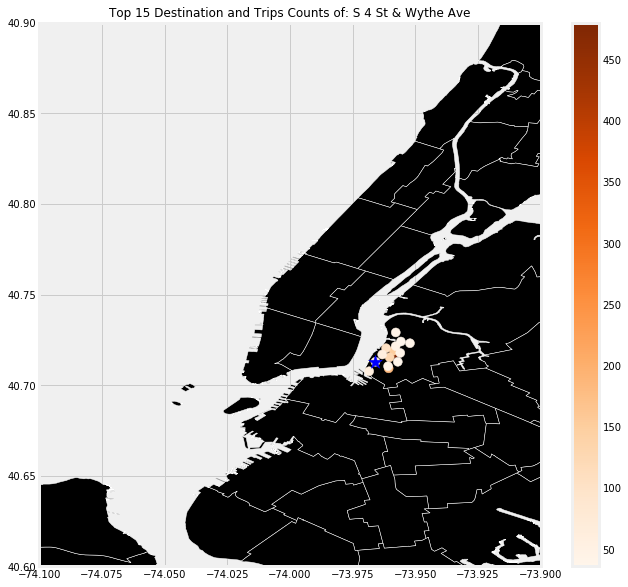

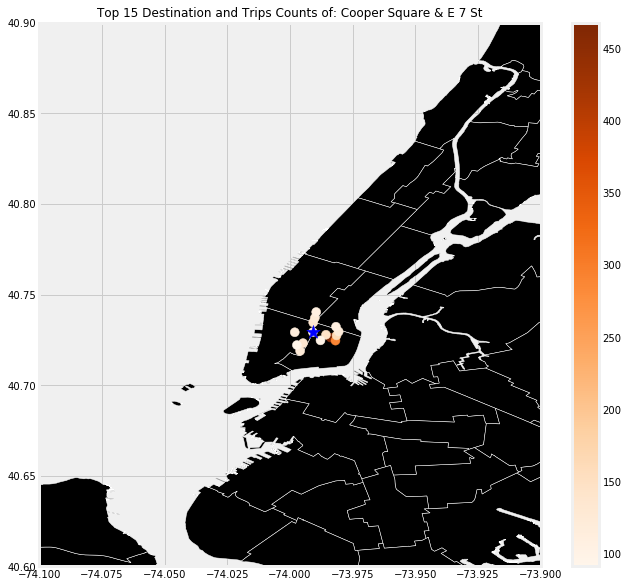

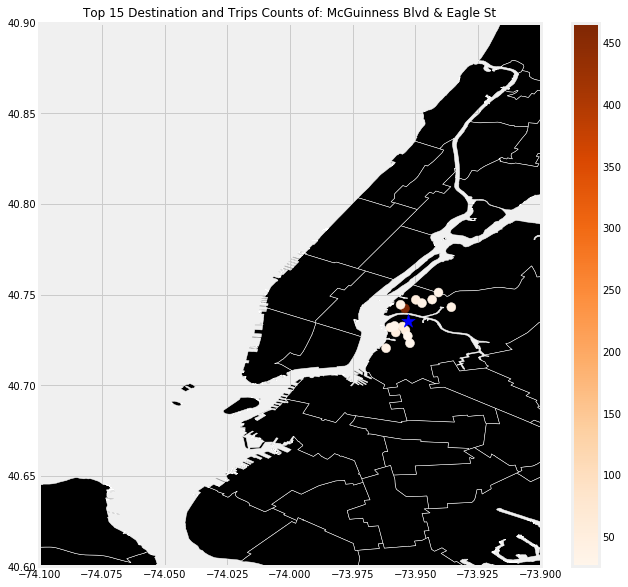

In [198]:
plotTopRoute(commonRoute, 15, 15)

---

# Next Steps

Additional Questions: 
- Does bike stations encourage multi-modal travelling?
- How many trips ends near a subway station?


# Potential Hypothesis Testing

the average number of arrival trips is higher compared to the ones that are remote from any subway stations.


# Key Methods 
- Pairwise Distance (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html)
- Spatial Visualization

In [46]:
commonRoute = gpd.GeoDataFrame(commonRoute, geometry = 'geometry_arv').sort_values("cnt", ascending = False)
commonRoute.dtypes

start station id      int64
end station id        int64
cnt                   int64
name_dep             object
lat_dep             float64
lon_dep             float64
name_arv             object
lat_arv             float64
lon_arv             float64
geometry_dep         object
geometry_arv         object
dtype: object

## Top Routes Including Origination and Destination

In [50]:
commonRoute.iloc[0:5, :]

start station id  end station id  cnt  \
91407              2006            2006  856   
80977               514             426  781   
56852               432            3263  770   
91484              2006            3282  701   
19228               281             281  578   

                                name_dep    lat_dep    lon_dep  \
91407             Central Park S & 6 Ave  40.765909 -73.976342   
80977                   12 Ave & W 40 St  40.760875 -74.002777   
56852                  E 7 St & Avenue A  40.726218 -73.983799   
91484             Central Park S & 6 Ave  40.765909 -73.976342   
19228  Grand Army Plaza & Central Park S  40.764397 -73.973715   

                                name_arv    lat_arv    lon_arv  \
91407             Central Park S & 6 Ave  40.765909 -73.976342   
80977              West St & Chambers St  40.717548 -74.013221   
56852             Cooper Square & E 7 St  40.729236 -73.990868   
91484                    5 Ave & E 88 St  40.783070 -73.959390   
19228  Grand Army Plaza & Central Park S  40.764397 -73.973715   

                                geometry_dep  \
91407       POINT (-73.97634151 40.76590936)   
80977       POINT (-74.00277668 40.76087502)   
56852       POINT (-73.98379855 40.72621788)   
91484       POINT (-73.97634151 40.76590936)   
19228  POINT (-73.97371465000001 40.7643971)   

                                       geometry_arv  
91407              POINT (-73.97634151 40.76590936)  
80977              POINT (-74.01322069 40.71754834)  
56852  POINT (-73.99086803197861 40.72923649910006)  
91484                    POINT (-73.95939 40.78307)  
19228         POINT (-73.97371465000001 40.7643971)

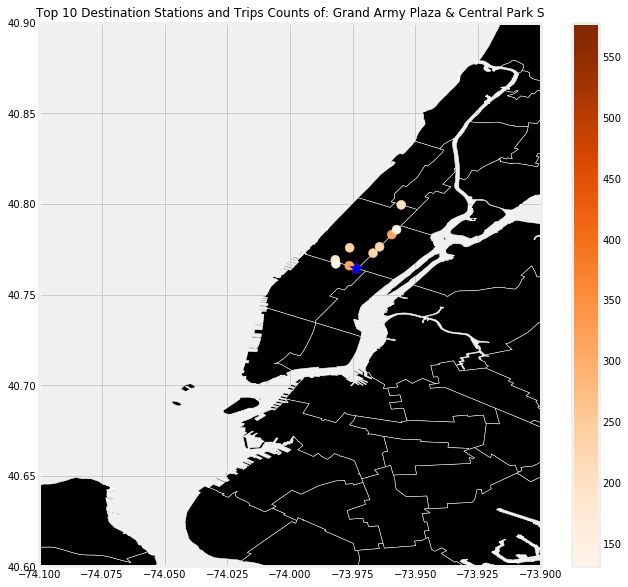

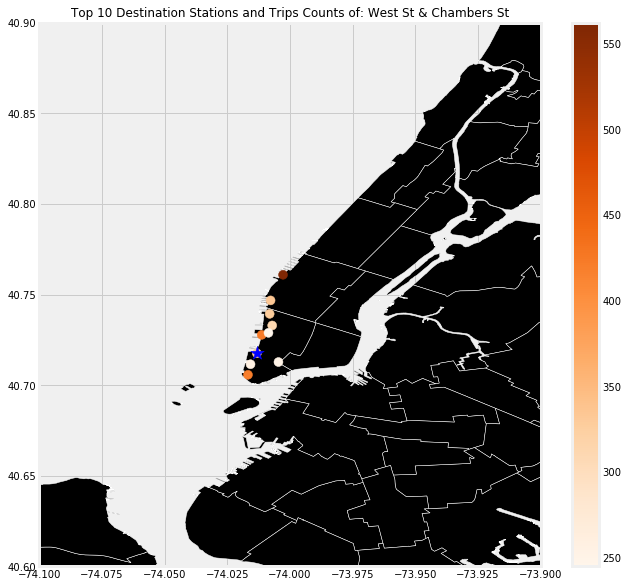

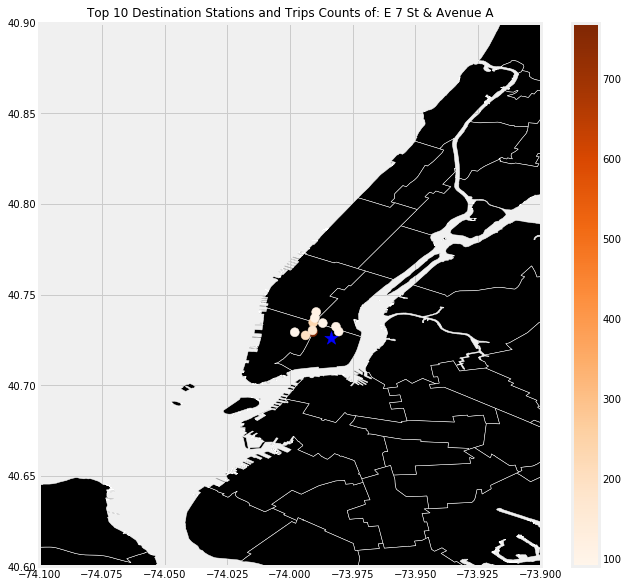

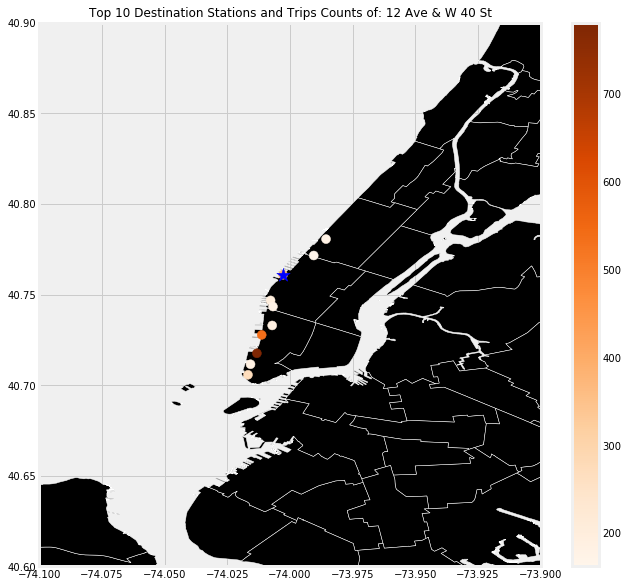

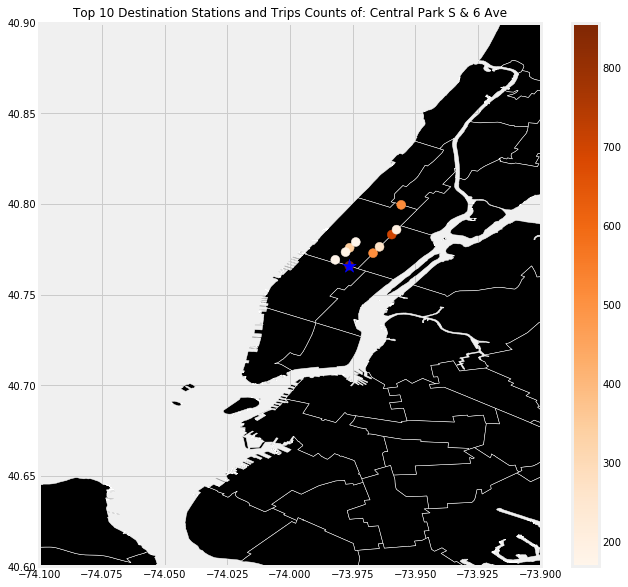

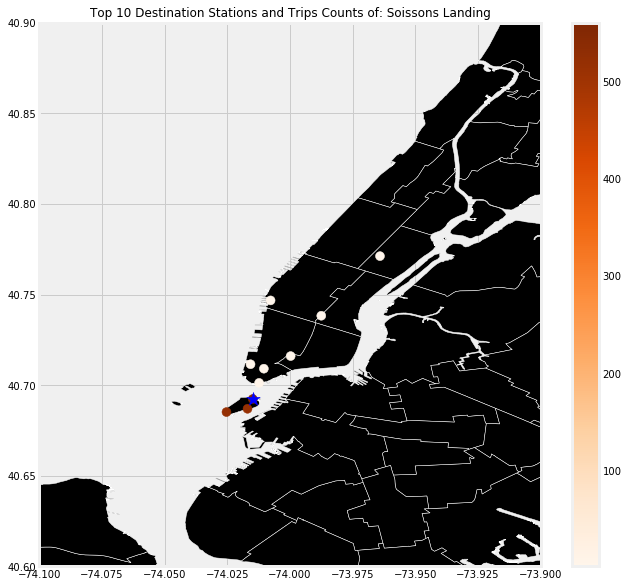

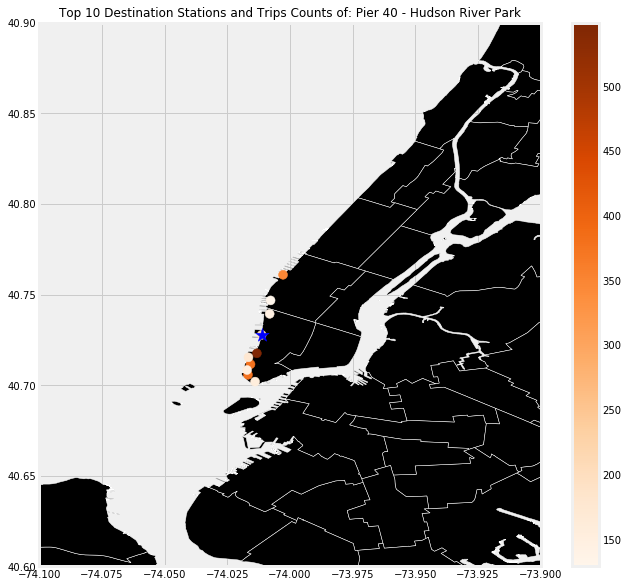

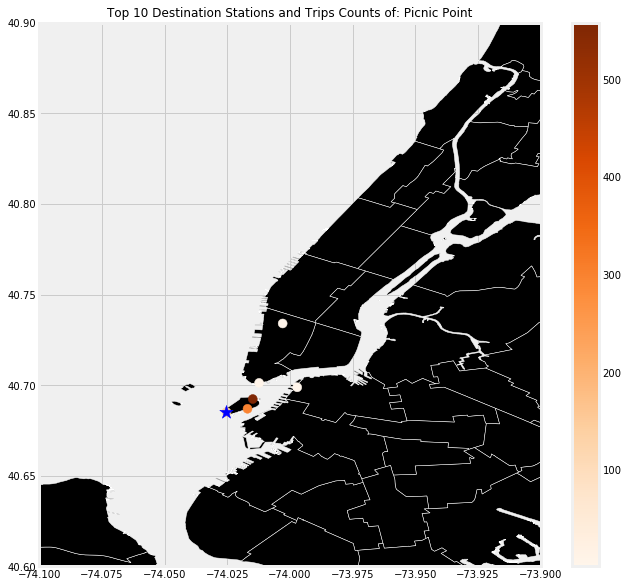

In [83]:
for station in unique_top_origin:

    f, ax = plt.subplots(figsize = (10,10));
    nyc_map.plot(ax = ax, color = "black", edgecolor = 'w');

    commonRoute[(commonRoute["start station id"] == station)][["end station id", "cnt", "geometry_arv"]].iloc[0:10, :]\
                    .plot(ax = ax, column = "cnt", cmap = "Oranges", markersize = 80, legend = True);

    uni_station[(uni_station.id == station)].plot(ax = ax, color = "blue", marker = "*", markersize = 200);
    station_name = uni_station[(uni_station.id == station)]["name"].values

    plt.xlim([-74.1, -73.9]);
    plt.ylim([40.6, 40.9]);
    plt.title("Top 10 Destination Stations and Trips Counts of: {}".format(station_name[0]), size = 12);